# Machina Quickstart notebook
- This notebook example is for beginners who use laptop.
- In Machina's architecture, sampling trajectory and training policy is detached.
- In this example you can try classic control tasks of [gym](https://gym.openai.com/envs/#classic_control).
    - On the task of 'Acrobot-v1', an agent can get reward when the tip of the rod is over the line.
- If you want to apply to your original tasks, you just define your tasks as environment and replace "env".

This sample code is consist of 4 components.

1. Preparation
    - environment
    - policy
    - sampler
1. Visualize behavior before trainning
1. Trainning
    - settings about trainning
    - train loop
1. Visualize behavior after trainning
    - load best model

## 1.Preparation
Let's prepare your environment, policy and sampler.

In [1]:
import numpy as np
import gym
import torch
import os

KeyboardInterrupt: 

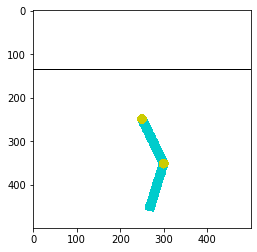

In [9]:
 import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Acrobot-v1')
env.reset()
for _ in range(1000):
    plt.imshow(env.render(mode='rgb_array'))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    env.step(env.action_space.sample())

In [4]:
# define your environment
env_name = 'Acrobot-v1'
env = gym.make(env_name)
obs = env.reset()
# show your environment. 
#env.render() # An Error occurs here: who use CUI based computer should comment out.

# check dimension of observation space and action space
observation_space = env.observation_space
action_space = env.action_space
print('obs:', observation_space)
print('act:', action_space)

obs: Box(6,)
act: Discrete(3)


In [10]:
# define your policy
from simple_net import PolNet,VNet
from machina.pols import CategoricalPol
from machina.vfuncs import DeterministicSVfunc
# policy
pol_net = PolNet(observation_space, action_space)
pol = CategoricalPol(observation_space, action_space, pol_net)
# value function
vf_net = VNet(observation_space)
vf = DeterministicSVfunc(observation_space, vf_net)

# set optimizer to both models
pol_lr = 1e-4
optim_pol = torch.optim.Adam(pol_net.parameters(), pol_lr)

vf_lr = 3e-4
optim_vf = torch.optim.Adam(vf_net.parameters(), vf_lr)

#  arguments of PPO
kl_beta = 1
gamma = 0.995
lam = 1 
clip_param = 0.2
epoch_per_iter = 50
batch_size = 64
max_grad_norm = 10

In [11]:
# registrate your environment and policy to sampler
from machina.samplers import EpiSampler
sampler = EpiSampler(env, pol, num_parallel=2, seed=42)

Process Process-2:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/hirobuchi.ryota/miniconda3/envs/machina/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hirobuchi.ryota/miniconda3/envs/machina/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/hirobuchi.ryota/miniconda3/envs/machina/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hirobuchi.ryota/miniconda3/envs/machina/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/hirobuchi.ryota/miniconda3/envs/machina/lib/python3.6/site-packages/machina/samplers/epi_sampler.py", line 123, in mp_sample
    time.sleep(0.1)
KeyboardInterrupt
  File "/home/hirobuchi.ryota/miniconda3/envs/machina/lib/python3.6/site-packages/machina/samplers/epi_sampler.py", line 123,

## 2.Visualize behavior before trainning
You can check initial policy's behavior.

In [7]:
import time
done = False
o = env.reset() 
for _ in range(150): # show 150 frames (=10 sec)
    if done:
        time.sleep(1) # when the boundary　of eposode
        o = env.reset()
    ac_real, ac, a_i = pol.deterministic_ac_real(torch.tensor(o, dtype=torch.float))
    ac_real = ac_real.reshape(pol.action_space.shape)
    next_o, r, done, e_i = env.step(np.array(ac_real))
    o = next_o
    time.sleep(1/15) # 15fps
    #env.render()

## 3.Trainning
You can edit train setting and train your policy. It takes several menutes.

In [8]:
# train your policy
from machina.traj import epi_functional as ef
from machina import logger
from machina.utils import measure
from machina.traj import Traj
from machina.algos import ppo_clip

# machina automatically write log (model ,scores, etc..)
log_dir_name = 'garbage'
if not os.path.exists(log_dir_name):
    os.mkdir(log_dir_name)
    os.mkdir(log_dir_name+'/models')
score_file = os.path.join(log_dir_name, 'progress.csv')
logger.add_tabular_output(score_file)

# counter and record for loop
total_epi = 0
total_step = 0
max_rew = -500

# how long will you train
max_episodes = 100 # for100 eposode

# max timesteps per eposode
max_steps_per_iter = 150 # 150 frames (= 10 sec)

In [9]:
# train loop
while max_episodes > total_epi:
    # sample trajectories
    with measure('sample'):
        epis = sampler.sample(pol, max_steps=max_steps_per_iter)

    # train from trajectories
    with measure('train'):
        traj = Traj()
        traj.add_epis(epis)
        
        # calulate advantage
        traj = ef.compute_vs(traj, vf)
        traj = ef.compute_rets(traj, gamma)
        traj = ef.compute_advs(traj, gamma, lam)
        traj = ef.centerize_advs(traj)
        traj = ef.compute_h_masks(traj)
        traj.register_epis()

        result_dict = ppo_clip.train(traj=traj, pol=pol, vf=vf, clip_param=clip_param,
                                     optim_pol=optim_pol, optim_vf=optim_vf, 
                                     epoch=epoch_per_iter, batch_size=batch_size,
                                     max_grad_norm=max_grad_norm)
    # update counter and record
    total_epi += traj.num_epi
    step = traj.num_step
    total_step += step
    rewards = [np.sum(epi['rews']) for epi in epis]
    mean_rew = np.mean(rewards)
    logger.record_results(log_dir_name, result_dict, score_file,
                          total_epi, step, total_step,
                          rewards,
                          plot_title=env_name)
    if mean_rew > max_rew:
        torch.save(pol.state_dict(), os.path.join(
            log_dir_name, 'models', 'pol_max.pkl'))
        torch.save(vf.state_dict(), os.path.join(
            log_dir_name, 'models', 'vf_max.pkl'))
        torch.save(optim_pol.state_dict(), os.path.join(
            log_dir_name, 'models', 'optim_pol_max.pkl'))
        torch.save(optim_vf.state_dict(), os.path.join(
            log_dir_name, 'models', 'optim_vf_max.pkl'))
        max_rew = mean_rew

    torch.save(pol.state_dict(), os.path.join(
        log_dir_name, 'models', 'pol_last.pkl'))
    torch.save(vf.state_dict(), os.path.join(
        log_dir_name, 'models', 'vf_last.pkl'))
    torch.save(optim_pol.state_dict(), os.path.join(
        log_dir_name, 'models', 'optim_pol_last.pkl'))
    torch.save(optim_vf.state_dict(), os.path.join(
        log_dir_name, 'models', 'optim_vf_last.pkl'))
    del traj
del sampler

2019-12-01 16:34:16.301546 JST | sample: 0.2769sec
2019-12-01 16:34:16.401927 JST | Optimizing...
2019-12-01 16:34:23.327971 JST | Optimization finished!
2019-12-01 16:34:23.328942 JST | train: 7.0266sec
2019-12-01 16:34:23.332159 JST | outdir /home/hirobuchi.ryota/rl/machina/example/quickstart/garbage
2019-12-01 16:34:23.337010 JST | --------------  -------------
2019-12-01 16:34:23.338124 JST | PolLossAverage     -0.0186607
2019-12-01 16:34:23.339180 JST | PolLossStd          0.127852
2019-12-01 16:34:23.340236 JST | PolLossMedian      -0.0228242
2019-12-01 16:34:23.341305 JST | PolLossMin         -0.426194
2019-12-01 16:34:23.342354 JST | PolLossMax          0.450402
2019-12-01 16:34:23.343411 JST | VfLossAverage    2522.24
2019-12-01 16:34:23.344661 JST | VfLossStd        2334.64
2019-12-01 16:34:23.345736 JST | VfLossMedian     1378.66
2019-12-01 16:34:23.346805 JST | VfLossMin         495.746
2019-12-01 16:34:23.347888 JST | VfLossMax       10297.1
2019-12-01 16:34:23.348964 JST 

2019-12-01 16:34:59.723209 JST | VfLossAverage    428.385
2019-12-01 16:34:59.724424 JST | VfLossStd        189.721
2019-12-01 16:34:59.725180 JST | VfLossMedian     377.336
2019-12-01 16:34:59.726810 JST | VfLossMin        191.5
2019-12-01 16:34:59.727563 JST | VfLossMax       1639.84
2019-12-01 16:34:59.729248 JST | RewardAverage   -500
2019-12-01 16:34:59.729964 JST | RewardStd          0
2019-12-01 16:34:59.736995 JST | RewardMedian    -500
2019-12-01 16:34:59.737893 JST | RewardMin       -500
2019-12-01 16:34:59.738779 JST | RewardMax       -500
2019-12-01 16:34:59.739666 JST | EpisodePerIter     2
2019-12-01 16:34:59.740568 JST | TotalEpisode      12
2019-12-01 16:34:59.741453 JST | StepPerIter     1000
2019-12-01 16:34:59.742337 JST | TotalStep       6000
2019-12-01 16:34:59.743219 JST | --------------  ------------
2019-12-01 16:35:00.124965 JST | sample: 0.3655sec
2019-12-01 16:35:00.137783 JST | Optimizing...
2019-12-01 16:35:06.945948 JST | Optimization finished!
2019-12-01 

2019-12-01 16:35:23.878154 JST | StepPerIter      413
2019-12-01 16:35:23.878901 JST | TotalStep       9659
2019-12-01 16:35:23.879655 JST | --------------  ------------
2019-12-01 16:35:24.123149 JST | sample: 0.2146sec
2019-12-01 16:35:24.129146 JST | Optimizing...
2019-12-01 16:35:26.405033 JST | Optimization finished!
2019-12-01 16:35:26.406876 JST | train: 2.2830sec
2019-12-01 16:35:26.407984 JST | outdir /home/hirobuchi.ryota/rl/machina/example/quickstart/garbage
2019-12-01 16:35:26.413380 JST | --------------  -------------
2019-12-01 16:35:26.414174 JST | PolLossAverage     -0.035936
2019-12-01 16:35:26.418325 JST | PolLossStd          0.107824
2019-12-01 16:35:26.419050 JST | PolLossMedian      -0.0352627
2019-12-01 16:35:26.419703 JST | PolLossMin         -0.352132
2019-12-01 16:35:26.423881 JST | PolLossMax          0.282715
2019-12-01 16:35:26.424555 JST | VfLossAverage      80.3588
2019-12-01 16:35:26.425359 JST | VfLossStd          81.3897
2019-12-01 16:35:26.426014 JST |

2019-12-01 16:35:41.142277 JST | PolLossAverage     -0.0356048
2019-12-01 16:35:41.143359 JST | PolLossStd          0.105093
2019-12-01 16:35:41.144436 JST | PolLossMedian      -0.0461001
2019-12-01 16:35:41.145515 JST | PolLossMin         -0.304932
2019-12-01 16:35:41.146586 JST | PolLossMax          0.330137
2019-12-01 16:35:41.147659 JST | VfLossAverage      58.388
2019-12-01 16:35:41.148740 JST | VfLossStd          23.8792
2019-12-01 16:35:41.149833 JST | VfLossMedian       52.8219
2019-12-01 16:35:41.150928 JST | VfLossMin          35.6721
2019-12-01 16:35:41.152024 JST | VfLossMax         199.781
2019-12-01 16:35:41.153116 JST | RewardAverage    -143
2019-12-01 16:35:41.154206 JST | RewardStd          18.7083
2019-12-01 16:35:41.155295 JST | RewardMedian     -148
2019-12-01 16:35:41.156401 JST | RewardMin        -163
2019-12-01 16:35:41.157492 JST | RewardMax        -118
2019-12-01 16:35:41.158498 JST | EpisodePerIter      3
2019-12-01 16:35:41.159492 JST | TotalEpisode       36


2019-12-01 16:35:53.839858 JST | VfLossMin          75.0437
2019-12-01 16:35:53.840820 JST | VfLossMax         472.011
2019-12-01 16:35:53.841780 JST | RewardAverage    -124
2019-12-01 16:35:53.842754 JST | RewardStd          28.4371
2019-12-01 16:35:53.843631 JST | RewardMedian     -113
2019-12-01 16:35:53.844515 JST | RewardMin        -163
2019-12-01 16:35:53.845395 JST | RewardMax         -96
2019-12-01 16:35:53.846275 JST | EpisodePerIter      3
2019-12-01 16:35:53.847151 JST | TotalEpisode       50
2019-12-01 16:35:53.848039 JST | StepPerIter       375
2019-12-01 16:35:53.848924 JST | TotalStep       13952
2019-12-01 16:35:53.849813 JST | --------------  -------------
2019-12-01 16:35:54.133736 JST | sample: 0.2641sec
2019-12-01 16:35:54.140002 JST | Optimizing...
2019-12-01 16:35:56.855991 JST | Optimization finished!
2019-12-01 16:35:56.857700 JST | train: 2.7232sec
2019-12-01 16:35:56.859366 JST | outdir /home/hirobuchi.ryota/rl/machina/example/quickstart/garbage
2019-12-01 16:

2019-12-01 16:36:07.821578 JST | StepPerIter       423
2019-12-01 16:36:07.822464 JST | TotalStep       16043
2019-12-01 16:36:07.823347 JST | --------------  -------------
2019-12-01 16:36:08.088008 JST | sample: 0.2443sec
2019-12-01 16:36:08.095301 JST | Optimizing...
2019-12-01 16:36:10.824687 JST | Optimization finished!
2019-12-01 16:36:10.826533 JST | train: 2.7378sec
2019-12-01 16:36:10.831188 JST | outdir /home/hirobuchi.ryota/rl/machina/example/quickstart/garbage
2019-12-01 16:36:10.835728 JST | --------------  -------------
2019-12-01 16:36:10.836432 JST | PolLossAverage     -0.0294708
2019-12-01 16:36:10.837148 JST | PolLossStd          0.111999
2019-12-01 16:36:10.841315 JST | PolLossMedian      -0.0358597
2019-12-01 16:36:10.845173 JST | PolLossMin         -0.344178
2019-12-01 16:36:10.845868 JST | PolLossMax          0.27216
2019-12-01 16:36:10.846567 JST | VfLossAverage      70.809
2019-12-01 16:36:10.847814 JST | VfLossStd          13.2947
2019-12-01 16:36:10.848555 JST

2019-12-01 16:36:22.459598 JST | PolLossAverage     -0.028426
2019-12-01 16:36:22.460330 JST | PolLossStd          0.10287
2019-12-01 16:36:22.462660 JST | PolLossMedian      -0.0187824
2019-12-01 16:36:22.466078 JST | PolLossMin         -0.29668
2019-12-01 16:36:22.467709 JST | PolLossMax          0.275501
2019-12-01 16:36:22.470103 JST | VfLossAverage      82.9812
2019-12-01 16:36:22.470931 JST | VfLossStd          45.0902
2019-12-01 16:36:22.471587 JST | VfLossMedian       69.7549
2019-12-01 16:36:22.472572 JST | VfLossMin          49.9335
2019-12-01 16:36:22.473387 JST | VfLossMax         356.845
2019-12-01 16:36:22.475144 JST | RewardAverage    -100
2019-12-01 16:36:22.479873 JST | RewardStd          19.1311
2019-12-01 16:36:22.481111 JST | RewardMedian     -112
2019-12-01 16:36:22.482124 JST | RewardMin        -115
2019-12-01 16:36:22.483109 JST | RewardMax         -73
2019-12-01 16:36:22.484121 JST | EpisodePerIter      3
2019-12-01 16:36:22.484799 JST | TotalEpisode       81
20

2019-12-01 16:36:35.234984 JST | VfLossMin           3.0132
2019-12-01 16:36:35.236069 JST | VfLossMax          89.0401
2019-12-01 16:36:35.236954 JST | RewardAverage    -120.667
2019-12-01 16:36:35.237853 JST | RewardStd           1.69967
2019-12-01 16:36:35.238733 JST | RewardMedian     -120
2019-12-01 16:36:35.239618 JST | RewardMin        -123
2019-12-01 16:36:35.240512 JST | RewardMax        -119
2019-12-01 16:36:35.241400 JST | EpisodePerIter      3
2019-12-01 16:36:35.242285 JST | TotalEpisode       96
2019-12-01 16:36:35.243170 JST | StepPerIter       365
2019-12-01 16:36:35.244060 JST | TotalStep       19931
2019-12-01 16:36:35.244948 JST | --------------  -------------
2019-12-01 16:36:35.498010 JST | sample: 0.2285sec
2019-12-01 16:36:35.510420 JST | Optimizing...
2019-12-01 16:36:37.790599 JST | Optimization finished!
2019-12-01 16:36:37.792878 JST | train: 2.2941sec
2019-12-01 16:36:37.794283 JST | outdir /home/hirobuchi.ryota/rl/machina/example/quickstart/garbage
2019-12-

- you can check progress by **garbage/Reward.png**

## 4.Visualize behavior after trainning
You can check best policy's behavior.

In [17]:
# load best policy
best_path = 'garbage/models/pol_max.pkl'
best_pol = CategoricalPol(observation_space, action_space, pol_net)
best_pol.load_state_dict(torch.load(best_path))

<All keys matched successfully>

KeyboardInterrupt: 

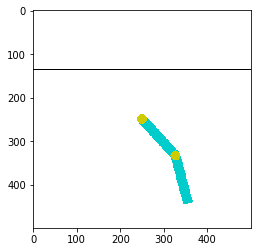

In [20]:
# show your trained policy's behavior

from gym import wrappers
import time
env = gym.make(env_name)
#env = wrappers.Monitor(env, "../video_data/sample_prog",force=True)#, video_callable=(lambda ep: ep % 100 == 0))
o = env.reset()

done = False

for step in range(300): # show 300 frames (=20 sec)
    if done:
        time.sleep(1) # when the boundary　of eposode
        o = env.reset()
    if step%3 ==0:
        plt.imshow(env.render(mode='rgb_array'))
        display.clear_output(wait=True)
        display.display(plt.gcf())
    ac_real, ac, a_i = pol.deterministic_ac_real(torch.tensor(o, dtype=torch.float))
    ac_real = ac_real.reshape(pol.action_space.shape)
    next_o, r, done, e_i = env.step(np.array(ac_real))
    o = next_o
    
    
    
    #time.sleep(1/15) # 15fps
    
    #env.render()

In [14]:
import cv2
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

cap = cv2.VideoCapture('../example/video_data/sample_prog/openaigym.video.1.1699.video000000.mp4')

while(cap.isOpened()):
    try:
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)

        display.clear_output(wait=True)
        display.display(plt.gcf())

    except KeyboardInterrupt:
        cap.release()

In [10]:
# close your environment
env.close()